In [31]:
import math

import random
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable, grad
import torchvision.utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity

from modules.dataset import LoadMRI, DatasetReconMRI
from modules.dataset import build_loaders
from modules.utils import kspace2image, image2kspace, complex2pseudo, pseudo2real, pseudo2complex, imsshow
from modules.solver import Solver
import modules.kspace_pytorch as cl

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocess

In [33]:
dataset = LoadMRI('./cine.npz')
CINE_INDEX = random.randint(0, 199)

In [34]:
data_test = DatasetReconMRI(dataset, acc=8, num_center_lines=10)

img_und: (2, 20, 192, 192), und_mask: (20, 192, 192), img_gt: (2, 20, 192, 192)
img_und: float32, und_mask: float32, img_gt: float32


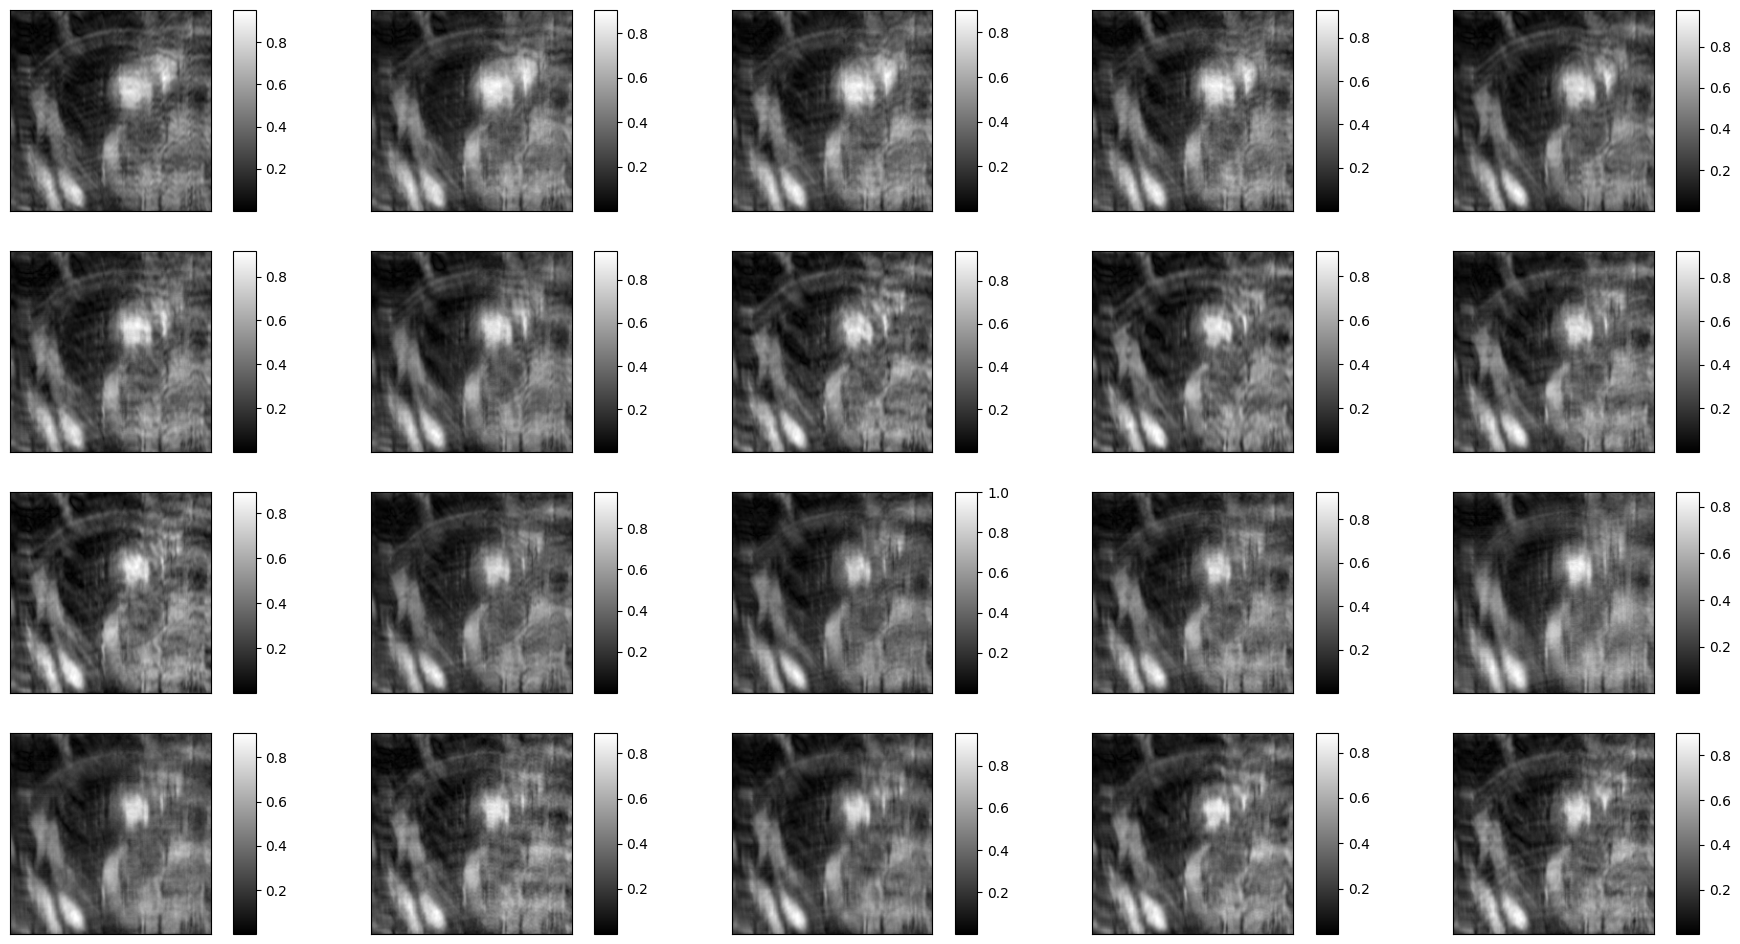

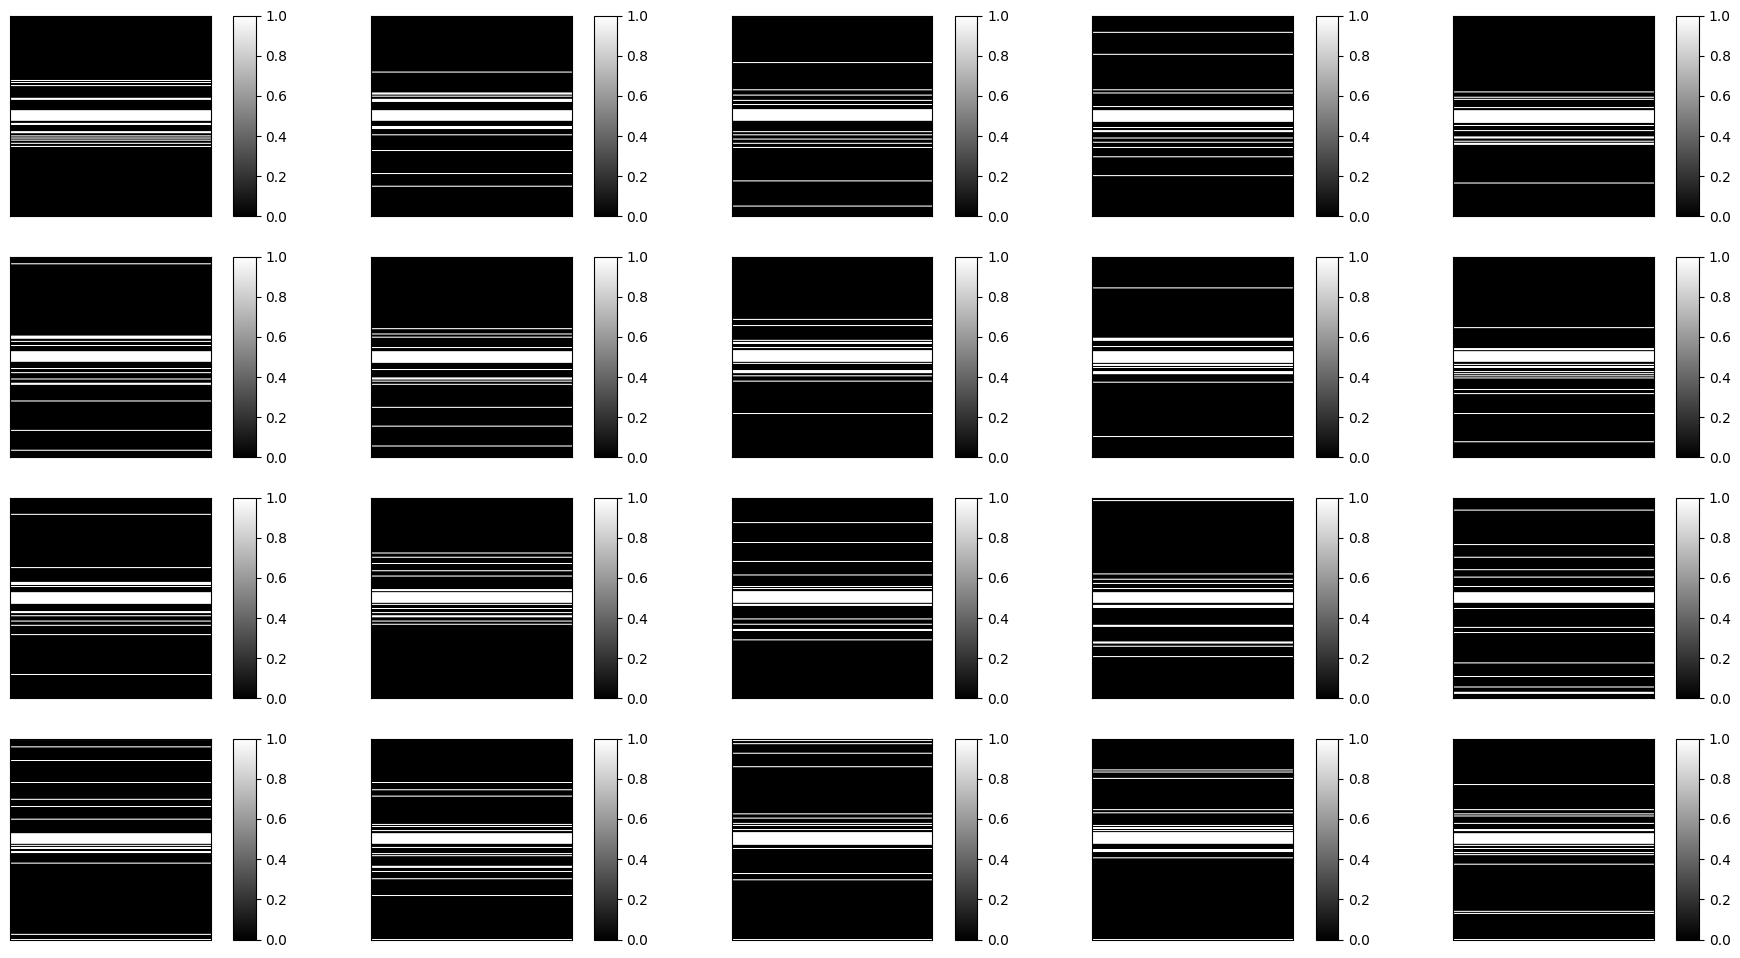

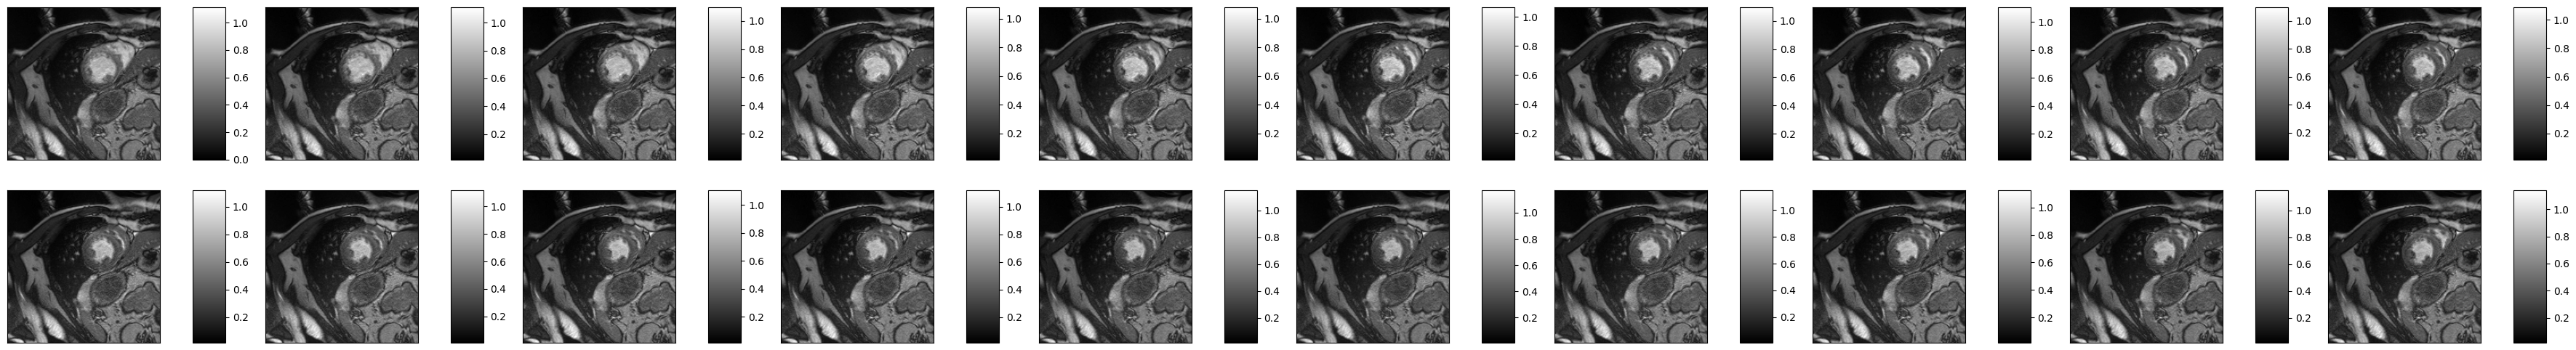

In [35]:
img_und, und_mask, img_gt = data_test[CINE_INDEX]
print(f"img_und: {img_und.shape}, und_mask: {und_mask.shape}, img_gt: {img_gt.shape}")
print(f"img_und: {img_und.dtype}, und_mask: {und_mask.dtype}, img_gt: {img_gt.dtype}")

img_und = np.abs(pseudo2real(img_und))
img_gt = np.abs(pseudo2real(img_gt))
# Try different index range in [0, 1000) to see different images in dataset.
imsshow(img_und, num_col=5, cmap='gray', is_colorbar=True)
imsshow(und_mask, num_col=5, cmap='gray', is_colorbar=True)
imsshow(img_gt, num_col=10, cmap='gray', is_colorbar=True)

In [36]:
TRAIN_INDICES = np.arange(0, 112)
VAL_INDICES = np.arange(112, 140)
TEST_INDICES = np.arange(140, 200)

train_loader, val_loader, test_loader = build_loaders(
    dataset, TRAIN_INDICES, VAL_INDICES, TEST_INDICES,
    batch_size=3  # Reduce this number if your computer does not has large gpu vram
)
print(f"Number of batches for train/val/test: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}")

Number of batches for train/val/test: 38/10/20


# Network

## from chatGPT

```python
device = torch.device('cuda:1')

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(-1, 128 * 3 * 3 * 3)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        
        return x
# 实例化一个CNN3D对象
net = CNN3D()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 准备数据并进行训练
for epoch in range(23):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        data.shape
        inputs, labels = data
        inputs = inputs.unsqueeze(1)  # 将数据的通道数变成1
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print('Epoch %d loss: %.3f' % (epoch+1, running_loss/len(train_loader)))

```

## Unet

In [37]:
class MRIReconstructionFramework(nn.Module):
    def __init__(self, recon_net: nn.Module):
        super().__init__()
        self.recon_net = recon_net

    def forward(self, x_und, mask):
        B, C, T, H, W = x_und.shape
        im_recon = self.recon_net(x_und)
        return im_recon

In [38]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.mpconv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2,
                                    diffZ // 2, diffZ - diffZ // 2,))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.conv1 = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.conv_out = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.conv_out(x)
        return logits


## MultiCNN with Dropout

In [ ]:
# Network definition
class MultiLayerCNN(nn.Module):
    def __init__(self, n_hidden=64):
        super().__init__()
        ######################## WRITE YOUR ANSWER HERE ########################
        self.conv1 = nn.Conv3d(2, n_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(n_hidden, 2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        ########################################################################
        self.drop = nn.Dropout3d(p=0.1)

    def forward(self, im_und):
        """
        - im_und: tensor[B, C=2, H, W]
        """
        ######################## WRITE YOUR ANSWER HERE ########################
        x = self.relu(self.drop(self.conv1(im_und)))
        x = self.relu(self.drop(self.conv2(x)))
        x = self.relu(self.drop(self.conv3(x)))
        x = self.relu(self.drop(self.conv4(x)))
        diff = self.conv5(x)
        im_recon = diff + im_und
        ########################################################################
        return im_recon


# test a forward
im_mock = torch.randn(5, 2, 20, 192, 192)
net = MultiLayerCNN()
out = net(im_mock)
print(out.shape)

## Train

In [39]:
class MSELoss():
    def __call__(self, im_recon, im_gt):
        """
        - im_recon: tensor[B, C=2, T, H, W]
        - im_gt: tensor[B, C=2, T, H, W]
        """
        B, C, T, H, W = im_recon.shape
        x = pseudo2real(im_recon)  # [B, T, H, W]
        y = pseudo2real(im_gt)     # [B, T, H, W]
        loss = torch.mean((y - x) ** 2) * B
        return loss


# test for loss computation
mse = MSELoss()
x_mock = torch.randn(5, 2, 20, 192, 192)
y_mock = torch.randn(5, 2, 20, 192, 192)
print(mse(x_mock, y_mock))

tensor(4.2925)


  0%|          | 0/112 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/28 [00:00<?, ?img/s]

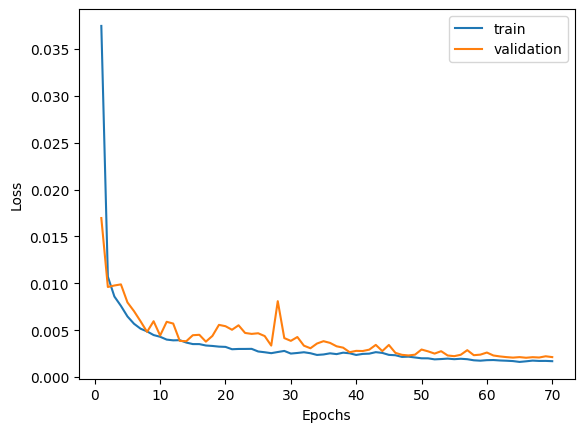

[Validation]:   0%|          | 0/60 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 26.429168542226154
[avg_SSIM] 0.814367026473332


In [40]:
# Define network
# net = MRIReconstructionFramework(
#     recon_net=MultiLayerCNN()
# )
net = MRIReconstructionFramework(UNet3D(2,2))

optimizer=torch.optim.Adam(
        net.parameters(),
        lr=0.0001
    )
# Training & Validation
solver = Solver(
    model=net,
    optimizer=optimizer,
    criterion=MSELoss(),
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 1/(epoch+1))
)

epochs_to_train = 70
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

data_load: 20, batch_size: 3
batch_size: 3, batch_offset: 2
torch.Size([3, 20, 192, 192])
torch.Size([3, 20, 192, 192])
torch.Size([3, 20, 192, 192])
(20, 192, 192)
(20, 192, 192)
(20, 192, 192)
(192, 192)
(192, 192)
(192, 192)


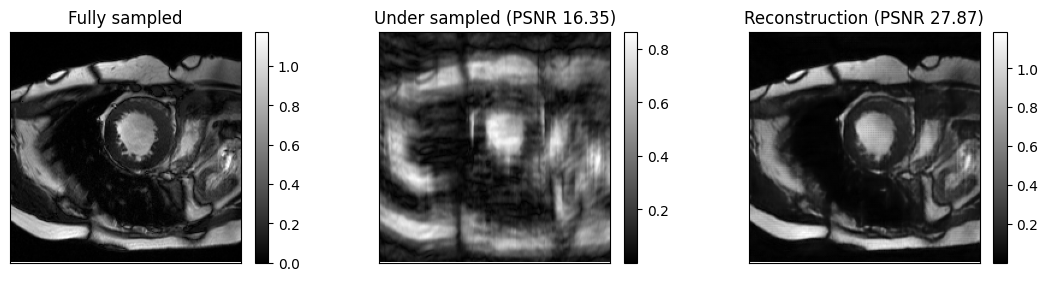

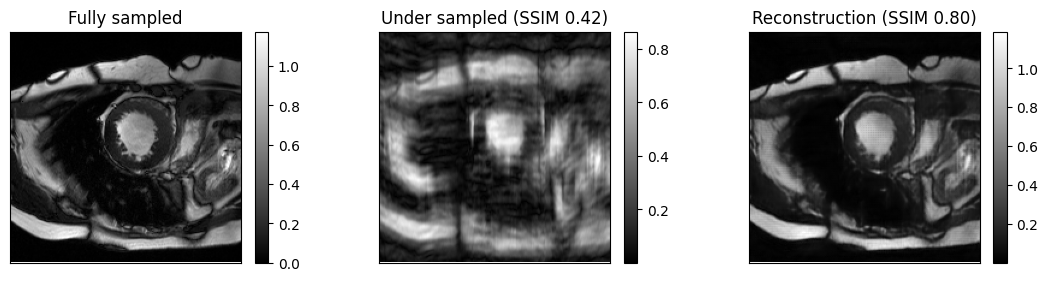

In [41]:
# changing data_index to see diffferent sample's visualization
data_index = 20 # range in [0, 60)
time_index = 10
solver.visualize(test_loader, idx=data_index,time_index=time_index, dpi=100)

In [ ]:
import time
timestamp = time.strftime("%m-%d_%H-%M-%S", time.localtime())
torch.save(model.state_dict(), f'{timestamp}-checkpoint.pth')